In [ ]:
!pip install -U datasets==3.6.0 huggingface_hub==0.33.1 fsspec==2025.3.0
!pip install --no-deps bitsandbytes==0.46.1 accelerate xformers==0.0.29.post3 peft==0.15.2 trl==0.19.0 triton cut_cross_entropy==25.1.1 unsloth_zoo==2025.6.8
!pip install --no-deps unsloth==2025.6.12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.33.4
    Uninstalling huggingface-hub-0.33.4:
      Successfully uninstalled huggingface-hub-0.33.4
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from huggingface_hub import login
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TrainingArguments
from transformers import pipeline

from unsloth import FastLanguageModel

/tmp/ipython-input-28-3408173340.py:13: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
## Authenticate Hugging Face
token = input("Enter Token")
login(token=token)

In [ ]:
# Load the dataset
dataset = load_dataset("gretelai/synthetic_text_to_sql", revision='main')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

(…)nthetic_text_to_sql_train.snappy.parquet:   0%|          | 0.00/32.4M [00:00<?, ?B/s]

(…)ynthetic_text_to_sql_test.snappy.parquet:   0%|          | 0.00/1.90M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5851 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation'],
        num_rows: 5851
    })
})

In [ ]:
# Convert the dataset to a pandas DataFrame for easier exploration
df_train = dataset['train'].to_pandas()
df_test = dataset['test'].to_pandas()

In [ ]:
print("Training data information:")
df_train.info()
print("\nTest data information:")
df_test.info()

Training data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   id                          100000 non-null  int32 
 1   domain                      100000 non-null  object
 2   domain_description          100000 non-null  object
 3   sql_complexity              100000 non-null  object
 4   sql_complexity_description  100000 non-null  object
 5   sql_task_type               100000 non-null  object
 6   sql_task_type_description   100000 non-null  object
 7   sql_prompt                  100000 non-null  object
 8   sql_context                 100000 non-null  object
 9   sql                         100000 non-null  object
 10  sql_explanation             100000 non-null  object
dtypes: int32(1), object(10)
memory usage: 8.0+ MB

Test data information:
<class 'pandas.core.frame.DataFrame'>
RangeInde

In [ ]:
def remove_insert_statements(sql_list):
    return ";".join([stmt.strip() for stmt in sql_list if 'insert into' not in stmt.lower() and stmt.strip()])

df_train['clean_sql_context'] = df_train['sql_context'].str.split(';').apply(remove_insert_statements)
df_test['clean_sql_context'] = df_test['sql_context'].str.split(';').apply(remove_insert_statements)


In [ ]:
# Display the first few rows of each dataset
print("\nFirst 5 rows of the training dataset:")
df_train.head()



First 5 rows of the training dataset:


,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation,clean_sql_context
0,5097,forestry,Comprehensive data on sustainable forest manag...,single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to...","Joins timber_sales and salesperson tables, gro...","CREATE TABLE salesperson (salesperson_id INT, ..."
1,5098,defense industry,"Defense contract data, military equipment main...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen...",This query groups the equipment_maintenance ta...,CREATE TABLE equipment_maintenance (equipment_...
2,5099,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...,This query counts the number of marine species...,"CREATE TABLE marine_species (name VARCHAR(50),..."
3,5100,financial services,Detailed financial data including investment s...,aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)...",This query calculates the total trade value an...,"CREATE TABLE trade_history (id INT, trader_id ..."
4,5101,energy,Energy market data covering renewable energy s...,window functions,"window functions (e.g., ROW_NUMBER, LEAD, LAG,...",analytics and reporting,"generating reports, dashboards, and analytical...",Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW...",The SQL query uses the ROW_NUMBER function to ...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
print("\nFirst 5 rows of the test dataset:")
df_test.head()


First 5 rows of the test dataset:


,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation,clean_sql_context
0,1,artificial intelligence,"AI data on algorithmic fairness, AI safety, ex...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",What is the average explainability score of cr...,"CREATE TABLE creative_ai (application_id INT, ...",SELECT AVG(explainability_score) FROM creative...,This SQL query calculates the average explaina...,"CREATE TABLE creative_ai (application_id INT, ..."
1,2,rural development,"Agricultural innovation metrics, rural infrast...",basic SQL,basic SQL with a simple select statement,data manipulation,"inserting, updating, or deleting records",Delete all records of rural infrastructure pro...,"CREATE TABLE rural_infrastructure (id INT, pro...",DELETE FROM rural_infrastructure WHERE country...,This SQL query deletes all records of rural in...,"CREATE TABLE rural_infrastructure (id INT, pro..."
2,3,aerospace,"Aircraft manufacturing data, satellite deploym...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",How many accidents have been recorded for Spac...,"CREATE TABLE Accidents (id INT, launch_provide...","SELECT launch_provider, COUNT(*) FROM Accident...",This query groups the Accidents table by the l...,"CREATE TABLE Accidents (id INT, launch_provide..."
3,4,aquaculture,"Aquatic farming data, fish stock management, o...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",What is the maximum quantity of seafood sold i...,"CREATE TABLE sales (id INT, location VARCHAR(2...",SELECT MAX(quantity) FROM sales;,Find the maximum quantity of seafood sold in a...,"CREATE TABLE sales (id INT, location VARCHAR(2..."
4,5,entertainment industry,"Audience demographics, viewership trends, cont...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",What is the total budget for movies released b...,"CREATE TABLE Movies_Release_Year (id INT, titl...",SELECT SUM(budget) FROM Movies_Release_Year WH...,This query calculates the total budget for mov...,"CREATE TABLE Movies_Release_Year (id INT, titl..."


In [ ]:
# Check the number of rows and columns
print("\nTraining dataset shape:", df_train.shape)
print("Test dataset shape:", df_test.shape)


Training dataset shape: (100000, 12)
Test dataset shape: (5851, 12)


In [ ]:
df_train[['sql_prompt','clean_sql_context','sql']].head(10)



,sql_prompt,clean_sql_context,sql
0,What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to..."
1,List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen..."
2,How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...
3,What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)..."
4,Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW..."
5,What is the total spending on humanitarian ass...,CREATE SCHEMA if not exists defense;CREATE TAB...,SELECT SUM(spending) FROM defense.eu_humanitar...
6,What is the average water temperature for each...,"CREATE TABLE SpeciesWaterTemp (SpeciesID int, ...","SELECT SpeciesName, AVG(WaterTemp) as AvgTemp ..."
7,Delete a program's outcome data,"CREATE TABLE Program_Outcomes (id INT, program...",DELETE FROM Program_Outcomes WHERE program_id ...
8,Find the total fare collected from passengers ...,CREATE TABLE bus_routes (route_name VARCHAR(50...,SELECT SUM(fare) FROM bus_routes WHERE route_n...
9,What is the average property size in inclusive...,CREATE TABLE Inclusive_Housing (Property_ID IN...,SELECT AVG(Property_Size) FROM Inclusive_Housi...


In [ ]:
df_train[df_train['domain'] == 'marine biology']

,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation,clean_sql_context
2,5099,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...,This query counts the number of marine species...,"CREATE TABLE marine_species (name VARCHAR(50),..."
11,5108,marine biology,"Comprehensive data on marine species, oceanogr...",subqueries,"subqueries, including correlated and nested su...",analytics and reporting,"generating reports, dashboards, and analytical...",What is the average sea surface temperature in...,"CREATE TABLE Ocean(id INT, region VARCHAR(20),...",SELECT AVG(temperature) FROM (SELECT temperatu...,This query calculates the average sea surface ...,"CREATE TABLE Ocean(id INT, region VARCHAR(20),..."
15,5112,marine biology,"Comprehensive data on marine species, oceanogr...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",Show the conservation status of marine mammals...,"CREATE TABLE mammals (id INT, name VARCHAR(255...","SELECT animal_group, conservation_status, year...",This query uses a view to combine the mammals ...,"CREATE TABLE mammals (id INT, name VARCHAR(255..."
207,5304,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",Count the number of whale sharks (Rhincodon ty...,"CREATE TABLE whale_sharks (id INT, species TEX...",SELECT SUM(count) FROM whale_sharks WHERE spec...,This query calculates the total number of whal...,"CREATE TABLE whale_sharks (id INT, species TEX..."
236,5333,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",Get the minimum surface salinity in the Arctic...,"CREATE TABLE ocean_salinity (id INT, location ...",SELECT MIN(salinity) FROM ocean_salinity WHERE...,This query finds the minimum surface salinity ...,"CREATE TABLE ocean_salinity (id INT, location ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
99587,89243,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",What is the total population of all marine spe...,CREATE TABLE marine_species_pacific (name VARC...,SELECT SUM(population) FROM marine_species_pac...,This query calculates the total population of ...,CREATE TABLE marine_species_pacific (name VARC...
99634,89290,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",What is the maximum depth in the Atlantic Ocea...,CREATE TABLE ocean_depths (station_name VARCHA...,SELECT MAX(atlantic_depth) FROM ocean_depths W...,Select the maximum value of the 'atlantic_dept...,CREATE TABLE ocean_depths (station_name VARCHA...
99766,89422,marine biology,"Comprehensive data on marine species, oceanogr...",subqueries,"subqueries, including correlated and nested su...",data manipulation,"inserting, updating, or deleting records",Update the conservation status of the species ...,CREATE TABLE marine_species (id INT PRIMARY KE...,UPDATE marine_species m SET m.conservation_sta...,This query identifies the species with the hig...,CREATE TABLE marine_species (id INT PRIMARY KE...
99819,89475,marine biology,"Comprehensive data on marine species, oceanogr...",aggregation,"aggregatio

In [ ]:
df_train['sql_complexity'].value_counts().index

Index(['basic SQL', 'aggregation', 'single join', 'subqueries',
       'window functions', 'multiple_joins', 'set operations', 'CTEs'],
      dtype='object', name='sql_complexity')

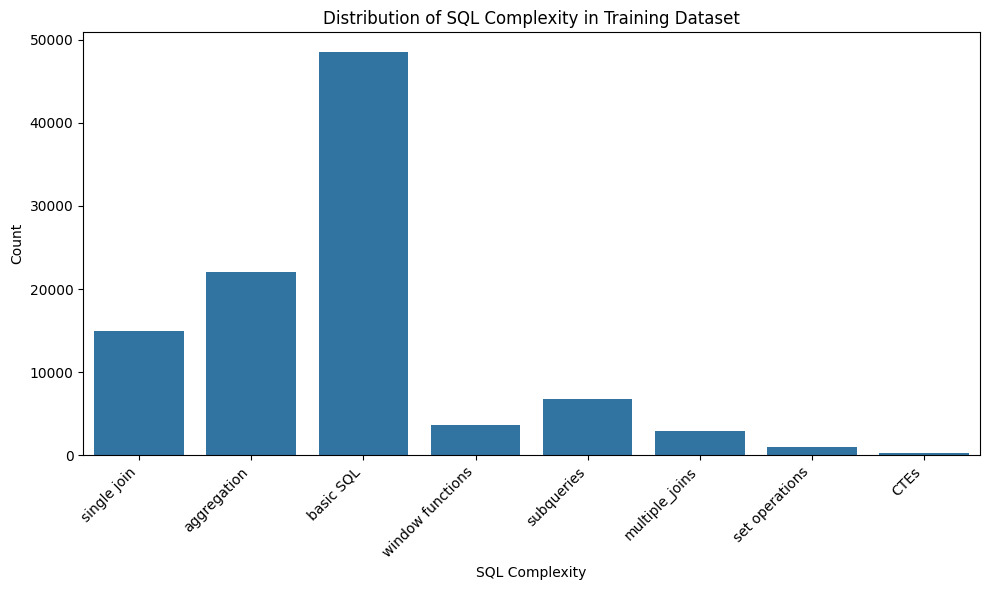

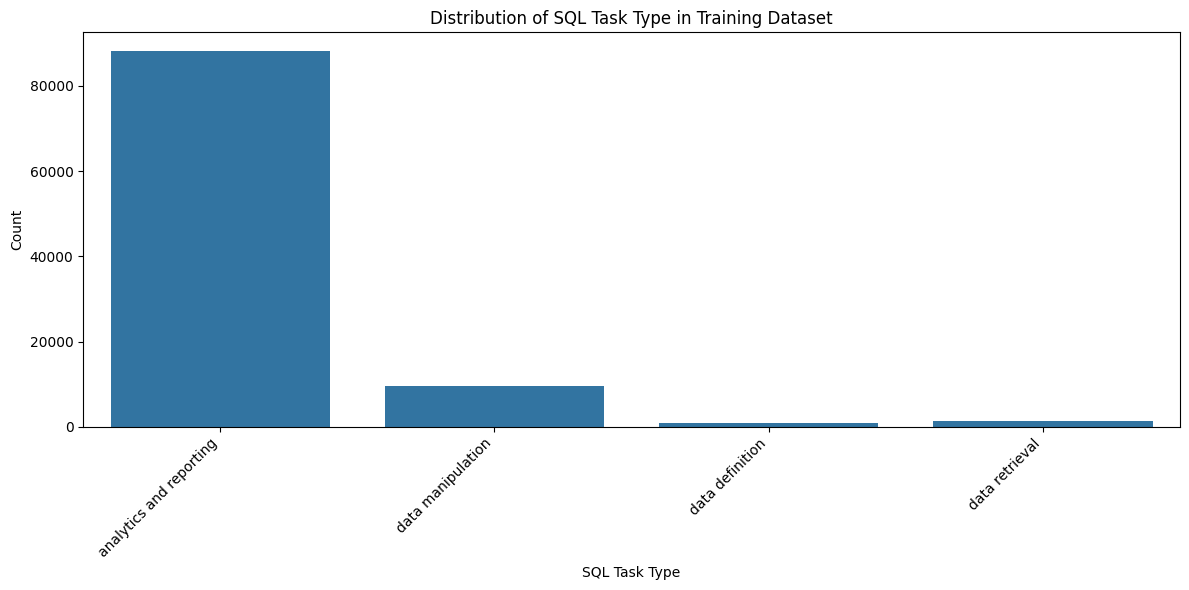

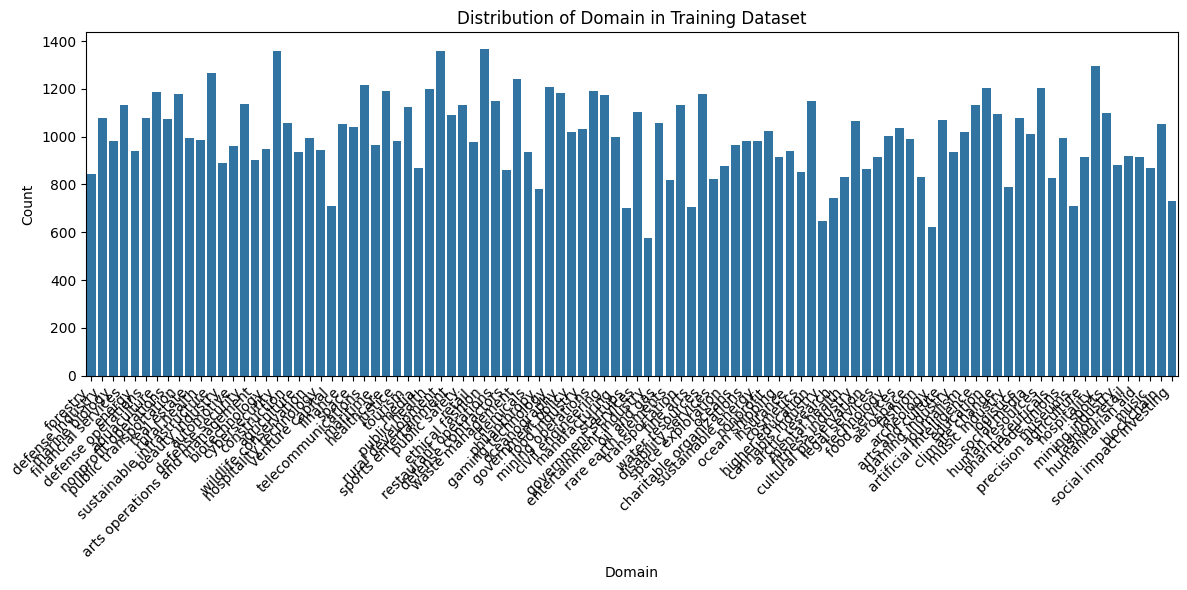

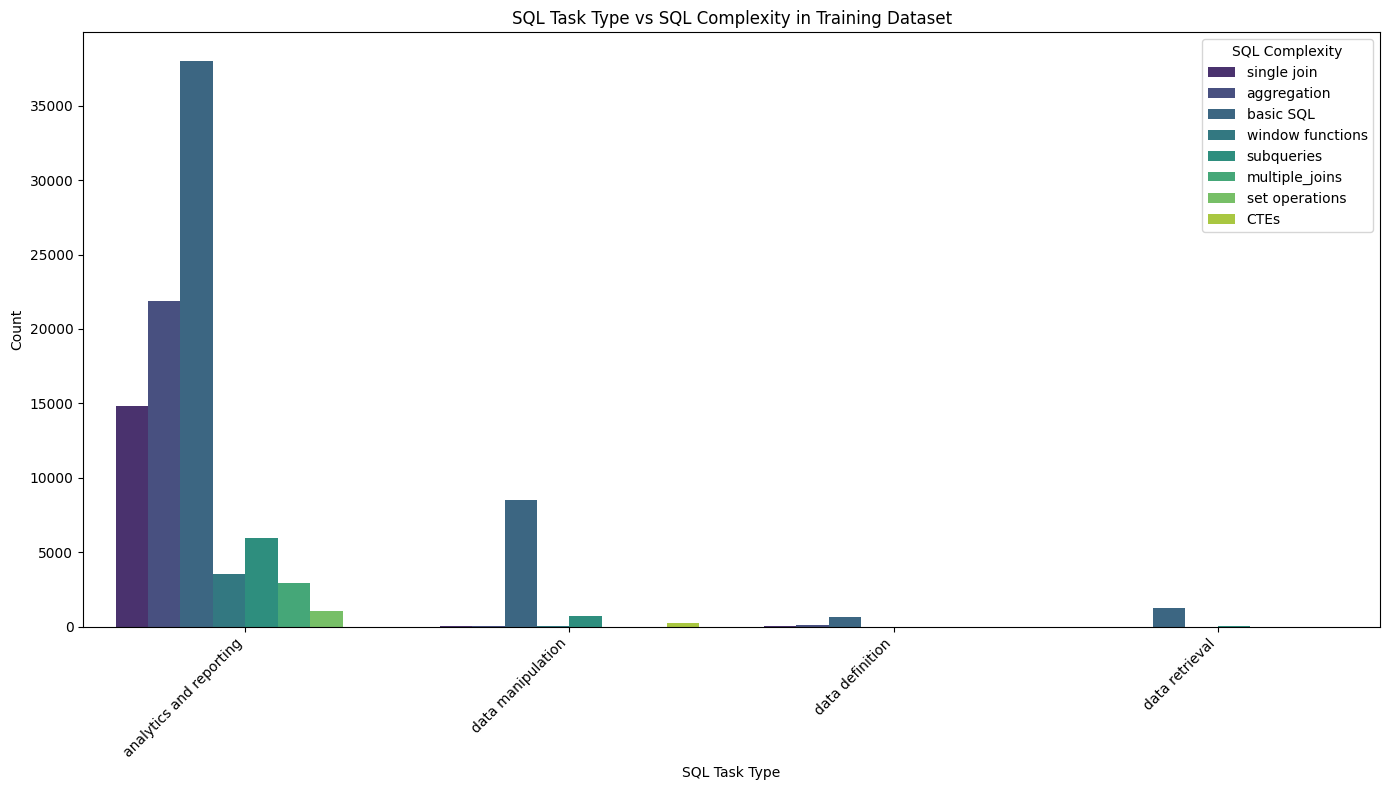

In [ ]:
# Plot the distribution of 'sql_complexity' in the training dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='sql_complexity')
plt.title('Distribution of SQL Complexity in Training Dataset')
plt.xlabel('SQL Complexity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot the distribution of 'sql_task_type' in the training dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, x='sql_task_type')
plt.title('Distribution of SQL Task Type in Training Dataset')
plt.xlabel('SQL Task Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot the distribution of 'domain' in the training dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, x='domain')
plt.title('Distribution of Domain in Training Dataset')
plt.xlabel('Domain')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Look at the relationship between complexity and task type (optional)
plt.figure(figsize=(14, 8))
sns.countplot(data=df_train, x='sql_task_type', hue='sql_complexity', palette='viridis')
plt.title('SQL Task Type vs SQL Complexity in Training Dataset')
plt.xlabel('SQL Task Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='SQL Complexity')
plt.tight_layout()
plt.show()


In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B",
    max_seq_length = 2048,
    load_in_4bit = True,
    load_in_8bit = False,
    full_finetuning = False,
)

==((====))==  Unsloth 2025.6.12: Fast Llama patching. Transformers: 4.53.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [ ]:
peft_model = FastLanguageModel.get_peft_model(
    model,
    r = 32,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2025.6.12 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
from datasets import Dataset, DatasetDict

# Create Dataset objects again from the pandas DataFrames since pre-processing has been done
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test[:200])

updated_dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

updated_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'clean_sql_context'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'clean_sql_context'],
        num_rows: 200
    })
})

In [ ]:
##Prepare the Dataset
prompt = """### Instruction:
{}

Context:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    instructions = examples["sql_prompt"]
    contexts = examples["clean_sql_context"]
    outputs      = examples["sql"]
    texts = []
    for instruction,context ,output in zip(instructions, contexts ,outputs):
        # Must add EOS_TOKEN
        text = prompt.format(instruction, context, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

formatted_dataset = updated_dataset.map(formatting_prompts_func, batched = True)
formatted_dataset

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'clean_sql_context', 'text'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation', 'clean_sql_context', 'text'],
        num_rows: 200
    })
})

In [ ]:
#Sample Training Data

for i in range(1):
    pprint(formatted_dataset['test'][i]['text'])
    print("-" * 80)
    print ()

('### Instruction:\n'
 'What is the average explainability score of creative AI applications in '
 "'Europe' and 'North America' in the 'creative_ai' table?\n"
 '\n'
 '### Response:\n'
 "SELECT AVG(explainability_score) FROM creative_ai WHERE region IN ('Europe', "
 "'North America');<|end_of_text|>")
--------------------------------------------------------------------------------



In [ ]:
#Fine Tune the Model
from trl import SFTConfig, SFTTrainer
trainer = SFTTrainer(
    model = peft_model,
    tokenizer = tokenizer, # Removed the tokenizer argument
    train_dataset = formatted_dataset["train"],
    eval_dataset = formatted_dataset["test"],
    dataset_text_field = "text",
    max_seq_length = 2048,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        # eval_strategy = "steps",
        # eval_steps = 60, #Evaluate every N steps
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
    ),
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/100000 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100,000 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 48,627,712 of 3,000,000,000 (1.62% trained)


Step,Training Loss
1,0.511000
2,0.479500
3,0.514300
4,0.330100
5,0.274700
6,0.202700
7,0.181800
8,0.197900
9,0.248900
10,0.245000


In [ ]:

peft_model.save_pretrained("sql_fintuned_10")

In [ ]:
from unsloth import FastLanguageModel
from transformers import pipeline

# Load model and tokenizer using Unsloth
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "sql_fintuned_10",
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
)
FastLanguageModel.for_inference(model)

# Create the generation pipeline
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)


==((====))==  Unsloth 2025.6.12: Fast Llama patching. Transformers: 4.53.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Device set to use cuda:0


In [ ]:
prompt

'### Instruction:\n{}\n\nContext:\n{}\n\n### Response:\n{}'

In [ ]:
# prompt: write code to predict on the test set and compare the results with actual and predicted by printing 10 random records from test

import random
import pandas as pd

def answer_question(question: str, context: str) -> str:
  """
  Generates an answer (SQL query) for a given question using the fine-tuned model.
  """
  formatted_prompt = prompt.format(question, context,"")
  response = generator(formatted_prompt, max_new_tokens=512)
  text_response = response[0]["generated_text"]
  return text_response.split("### Response:")[1].strip()

# Get 10 random indices from the test dataset
random_indices = random.sample(range(len(test_dataset)), 10)

results = []

print("Comparing Actual vs Predicted SQL Queries (10 Random Records from Test Set):")
print("-" * 100)

for i in random_indices:
    test_record = test_dataset[i]
    actual_sql = test_record['sql']
    question = test_record['sql_prompt']
    context = test_record['clean_sql_context']

    # Get the predicted SQL query
    predicted_sql = answer_question(question, context)

    print(f"Record Index: {i}")
    print(f"Prompt: {question}")
    print(f"Actual SQL: {actual_sql}")
    print(f"Predicted SQL: {predicted_sql}")
    print("-" * 100)

    results.append({
        'Record Index': i,
        'Prompt': question,
        'Actual SQL': actual_sql,
        'Predicted SQL': predicted_sql
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the DataFrame
print("\nResults DataFrame:")
display(results_df)

Comparing Actual vs Predicted SQL Queries (10 Random Records from Test Set):
----------------------------------------------------------------------------------------------------
Record Index: 77
Prompt: How many unions have more than 5000 members in the 'Education' sector?
Actual SQL: SELECT COUNT(*) FROM Unions WHERE Sector = 'Education' GROUP BY Sector HAVING COUNT(*) > 5000;
Predicted SQL: SELECT COUNT(*) FROM Unions WHERE Sector = 'Education' AND Membership > 5000;
----------------------------------------------------------------------------------------------------
Record Index: 49
Prompt: List the names and treatment approaches of therapists who have treated more than 50 patients with depression?
Actual SQL: SELECT therapists.name, therapists.treatment_approach FROM therapists JOIN (SELECT therapist_id, COUNT(*) AS patient_count FROM patients WHERE condition = 'depression' GROUP BY therapist_id HAVING patient_count > 50) AS patient_counts ON therapists.therapist_id = patient_counts

,Record Index,Prompt,Actual SQL,Predicted SQL
0,77,How many unions have more than 5000 members in...,SELECT COUNT(*) FROM Unions WHERE Sector = 'Ed...,SELECT COUNT(*) FROM Unions WHERE Sector = 'Ed...
1,49,List the names and treatment approaches of the...,"SELECT therapists.name, therapists.treatment_a...","SELECT t.name, t.treatment_approach FROM patie..."
2,81,What is the average landfill tipping fee for e...,"SELECT region, AVG(tipping_fee) FROM Landfill_...","SELECT region, AVG(tipping_fee) as avg_tipping..."
3,146,What is the total cost of ingredients for glut...,SELECT SUM(cost) FROM ingredients WHERE is_glu...,SELECT SUM(cost) FROM ingredients WHERE is_glu...
4,190,What is the total number of transactions perfo...,SELECT COUNT(*) FROM transactions;,SELECT SUM(count) FROM transactions WHERE app_...
5,28,What is the average salary for each department...,"SELECT Department, AVG(Salary) FROM Employees ...","SELECT Department, AVG(Salary) as Avg_Salary F..."
6,30,List renewable energy projects in India with a...,SELECT name FROM renewable_project WHERE count...,SELECT * FROM renewable_project WHERE country ...
7,151,Delete all comments made by users under 18 yea...,"DELETE FROM comments WHERE DATEDIFF('day', cre...",DELETE FROM comments WHERE user_id IN (SELECT ...
8,164,What is the total revenue for 'Breakfast' menu...,SELECT SUM(r.revenue) FROM menus m JOIN revenu...,SELECT SUM(revenue) FROM revenue JOIN menus ON...
9,56,What is the average rating of movies by direct...,"SELECT Director, AVG(Rating) as AverageRating ...",SELECT AVG(Rating) FROM DirectorMoviesRating W...
